In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pyvista as pv
from os import listdir
from os.path import isfile, join

In [23]:
mypath = '../../data/MLgSA/wss/'
mypath1 = '../../data/MLgSA/New_wss/'

onlyfiles = np.asarray([f for f in listdir(mypath) if isfile(join(mypath, f))])
onlyfiles1 = np.asarray([f for f in listdir(mypath1) if isfile(join(mypath1, f))])

onlyfiles.sort()
onlyfiles1.sort()

print(len(onlyfiles), len(onlyfiles1))

short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])
short_list1 = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles1])
# short_list = np.asarray([s[5:23] if s[19] == 'l' else s[5:24] for s in onlyfiles])

108 30


In [24]:
meshes = []

for f in onlyfiles:
    reader = pv.get_reader(mypath + f)
    meshes.append(reader.read())
    
for f in onlyfiles1:
    reader = pv.get_reader(mypath1 + f)
    meshes.append(reader.read())

In [25]:
len(meshes)

138

In [26]:
dl = []

In [27]:
for mesh in meshes:
    dl.append(np.asarray(mesh.point_data.values()))

In [28]:
data = np.concatenate(dl, axis=1)

In [29]:
data.shape

(4, 3957363)

In [30]:
mins = np.min(data, axis=1)
print(mins)

[           nan 1.54482502e-06            nan 1.17441243e-06]


In [31]:
maxs = np.max(data, axis=1)
print(maxs)

[          nan 1674.87182814           nan  639.66460845]


In [ ]:
mesh = np.asarray(meshes[0].point_data.values())

In [ ]:
# check if there are any nans

np.argwhere(np.isnan(data))

In [ ]:
scale = np.reciprocal(maxs - mins)
mins = mins.reshape(-1,1)
shifted = mesh - mins
print(mesh[:,0])
print(shifted[:, 0])

In [ ]:
print(scale)

In [ ]:
scaledmesh=shifted*scale.reshape(-1,1)

In [ ]:
plt.plot(scaledmesh[0])

In [ ]:
def get_scaled(mesh, mins=mins, maxs=maxs):
    scale = np.reciprocal(maxs - mins)
    mins = mins.reshape(-1,1)
    shifted = mesh - mins
    return shifted*scale.reshape(-1,1)

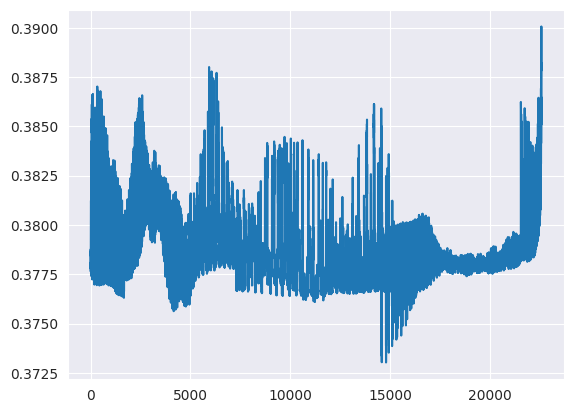

In [76]:
j = 58
mesh = np.asarray(meshes[j].point_data.values())
plt.plot(get_scaled(mesh)[0])

In [ ]:
onlyfiles[1]

In [ ]:
cols = ['longitudinal_WSS_@_t=1.1', 'non-directional_WSS_@_t=1.1', 'longitudinal_WSS_@_t=1.55', 'non-directional_WSS_@_t=1.55']

In [78]:
plotter = pv.Plotter()
plotter.add_mesh(meshes[58], scalars=cols[2])
plotter.show()

Widget(value='<iframe src="http://localhost:37133/index.html?ui=P_0x7f7d9ebf9fd0_12&reconnect=auto" class="pyv…

In [205]:
node_data = np.asarray(meshes[33].point_data['longitudinal_WSS_@_t=1.1'])
nan_indices = np.where(np.isnan(np.asarray(meshes[33].point_data['longitudinal_WSS_@_t=1.1'])))[0]

In [206]:
nan_indices

array([6297, 6298, 6299, ..., 9341, 9344, 9345])

In [215]:
np.asarray(meshes[33].point_data.values())[:, 6297]

array([          nan,   44.29682824,           nan,   16.43818216,
       6297.        ])

In [73]:
valid_mask = ~np.isnan(node_data)
valid_indices = np.where(valid_mask)[0]
sub_mesh = meshes[33].extract_points(valid_indices)

In [74]:
new_mesh = pv.UnstructuredGrid()

# Add valid points
new_mesh.points = sub_mesh.points

# Add valid cells (connectivity)
new_mesh.cells = sub_mesh.cells
new_mesh.celltypes = sub_mesh.celltypes

# If your mesh has cell data or point data, you can transfer it as well
new_mesh.point_data['longitudinal_WSS_@_t=1.1'] = sub_mesh.point_data['longitudinal_WSS_@_t=1.1']

AttributeError: can't set attribute

In [ ]:
plotter = pv.Plotter()
plotter.add_mesh(new_mesh, show_edges=True)
plotter.show()

In [40]:
def remove_nan_nodes(mesh, ind):
    values = mesh.point_data.values()
    if np.isnan(values).any():
        print('yolo', ind)
        nan_indices = np.where(np.isnan(values))[0]
        keep_indices = np.setdiff1d(np.arange(mesh.number_of_points), nan_indices)

        # Extract the new points and values without NaNs
        new_points = mesh.points[keep_indices]
        new_values = values[keep_indices]

        # Update cell connectivity
        new_cells = []
        for i in range(mesh.n_cells):
            cell = mesh.get_cell(i)
            cell_points = cell.point_ids
            new_cell_points = [point for point in cell_points if point not in nan_indices]
            if len(new_cell_points) == len(cell_points):  # Keep cell if no point was removed
                new_cells.append([len(new_cell_points)] + new_cell_points)

        if not new_cells:
            return None  # If no valid cells remain, return None

        # Flatten the new cell connectivity list
        new_cells_flat = [item for sublist in new_cells for item in sublist]

        # Create a new unstructured grid with the cleaned data
        new_grid = pv.UnstructuredGrid(new_cells_flat, mesh.celltypes, new_points)
        new_grid.add_field_data(new_values)
        return new_grid
    return mesh

In [50]:
indices_with_nan = []
cleaned_meshes = []
for i, mesh in enumerate(meshes):
    if np.isnan(mesh.point_data.values()).any():
        print(i)
        # indices_with_nan.append(i)
        # cleaned_mesh = remove_nan_nodes(mesh, i)
        # if cleaned_mesh is not None:
        #     cleaned_meshes.append(cleaned_mesh)
        # else:
        #     cleaned_meshes.append(mesh)

33


In [203]:
mesh = meshes[33]

In [204]:
mesh

UnstructuredGrid (0x7f7de0757a60)
  N Cells:    64245
  N Points:   33660
  X Bounds:   -3.926e+01, -1.194e+01
  Y Bounds:   -1.643e+01, 1.845e+01
  Z Bounds:   -1.145e+02, -4.116e+01
  N Arrays:   6

In [191]:
polydata = mesh.extract_surface()
edges = polydata.extract_feature_edges(boundary_edges=True,
                                       feature_edges=False,
                                       manifold_edges=False,
                                       non_manifold_edges=False)

In [192]:
boundary_point_ids = np.unique(edges.point_data['vtkOriginalPointIds'])
is_boundary = np.zeros(polydata.number_of_points, dtype=bool)
is_boundary[boundary_point_ids] = True

In [193]:
mesh_without_boundary = polydata.remove_points(boundary_point_ids)[0]

In [194]:
mesh_without_boundary

PolyData (0x7f7d85736460)
  N Cells:    31985
  N Points:   16114
  N Strips:   0
  X Bounds:   9.237e+00, 3.033e+01
  Y Bounds:   -5.315e+00, 1.931e+01
  Z Bounds:   -1.075e+02, -4.519e+01
  N Arrays:   6

In [195]:
curv_values =  polydata.curvature(curv_type='mean')
interior_curv_values = np.copy(curv_values)
interior_curv_values[is_boundary] = np.nan  # Mask boundary nodes

In [196]:
max_curv_indices = np.argsort(interior_curv_values)[-500:]
max_curv_nodes = mesh.points[max_curv_indices]

In [197]:
# Create a PyVista plotter object
plotter = pv.Plotter()

# Add the original mesh to the plotter
plotter.add_mesh(polydata, show_edges=True, opacity=0.5)

# Highlight the nodes with the largest curvature
plotter.add_points(max_curv_nodes, color='red', point_size=10)

# Display the plot
plotter.show()


Widget(value='<iframe src="http://localhost:37133/index.html?ui=P_0x7f7d857347c0_27&reconnect=auto" class="pyv…

In [198]:
# Getting points with the maximum wss
data = mesh.point_data.values()[1]
max_indices = np.argsort(data)[-500:]
max_nodes = mesh.points[max_indices]

In [199]:
plotter = pv.Plotter()

# Add the original mesh to the plotter
plotter.add_mesh(polydata, show_edges=True, opacity=0.5)

# Highlight the nodes with the largest curvature
plotter.add_points(max_nodes, color='red', point_size=10)

# Display the plot
plotter.show()


Widget(value='<iframe src="http://localhost:37133/index.html?ui=P_0x7f7d9e054730_28&reconnect=auto" class="pyv…

In [200]:
# cross-sectional area
from scipy.spatial import ConvexHull

principal_axis = 'y'
n_slices = 1000  # Number of slices along the principal axis


bounds = polydata.bounds
y_min, y_max = bounds[2], bounds[3]
y_slices = np.linspace(y_min, y_max, n_slices)

cross_sections = []
areas = []

for y in y_slices:
    slice = mesh_without_boundary.slice(normal=[0, 1, 0], origin=[0, y, 0])
    if slice.n_points >= 3:
        hull = ConvexHull(slice.points[:, [0, 2]])  # Use x and z for the convex hull
        cross_sections.append(slice)
        areas.append(hull.volume)
    else:
        areas.append(np.inf)  # Assign a high value to ignore this slice

areas = np.array(areas)

print(len(areas), len(cross_sections))

min_area_index = np.argmin(areas[:-3])
bottleneck_slice = cross_sections[min_area_index]
bottleneck_location = y_slices[min_area_index]

1000 992


In [201]:
# Create a PyVista plotter object
plotter = pv.Plotter()

# Add the original mesh to the plotter
plotter.add_mesh(polydata, show_edges=True, opacity=0.5)

# Highlight the bottleneck slice
plotter.add_mesh(bottleneck_slice, color='red', line_width=5)

# Display the plot
plotter.show()


Widget(value='<iframe src="http://localhost:37133/index.html?ui=P_0x7f7d84c74610_29&reconnect=auto" class="pyv…